In [1]:
import os
import numpy as np
import pandas
import os
import skimage
from scipy import ndimage, signal
from skimage import exposure
import matplotlib.pyplot as plt
import glob
from skimage import io
import scipy
from scipy import signal
from skimage import feature
from tqdm import tqdm_notebook as tqdm
import json
from matplotlib_scalebar.scalebar import ScaleBar
import networkx as nx
import seaborn as sns

In [2]:
def _getProperties(dic):
    
    nDead = 0

    G=nx.Graph()
    zCells = []
    yCells = []
    xCells = []
    
    G.add_nodes_from(dic.keys())
        
    _Cells = dic['cells']
    
    for key in _Cells.keys():
    
        neighbours = _Cells[key]['neighbours']
        zCells.append(_Cells[key]['z'])
        xCells.append(_Cells[key]['x'])
        yCells.append(_Cells[key]['y'])
    
        for node in neighbours:
    
            G.add_edge(key, node)
        
        if _Cells[key]['state'] == 'Dead':
            
            nDead += 1
        
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence

    return G, degree_sequence, nDead, zCells, xCells, yCells

In [72]:
def _getAllGraphs(path):
    
    df = pandas.DataFrame()
    i = 0
    
    positionFrame = pandas.DataFrame()
    j = 0
    
    degree = []
    zSph = []
    xSph = []
    ySph = []
    
    for dicName in tqdm(sorted(glob.glob(path + r'/' + '*.json'))):
                
        with open(dicName, "r") as read_file:
            data = json.load(read_file)
            
        _, sphNum = dicName.split('spheroid_')
        sphNum, _ = sphNum.split('.')
        sphNum, time = sphNum.split('_')
                    
        G, deg, nDead, zCells, xCells, yCells = _getProperties(data)

        locPosition = pandas.DataFrame(np.array([np.asarray(zCells), np.asarray(yCells), np.asarray(xCells)]).T, columns = ['z', 'y', 'x'])
        locPosition['time'] = time
        locPosition['spheroid'] = sphNum

        positionFrame = positionFrame.append(locPosition)

        degree += deg
        zSph += zCells
        xSph += xCells
        ySph += yCells

        df.loc[i, 'label'] = int(sphNum)
        df.loc[i, 'time'] = int(time)
        df.loc[i, 'n'] = len(G)
        df.loc[i, 'nDead'] = nDead
        df.loc[i, 'density'] = nx.density(G)
        df.loc[i, 'clustering'] = nx.average_clustering(G)
        df.loc[i, 'degree'] = np.mean(deg)
        i += 1

        # print "Degree sequence", degree_sequence

    degreeCount = collections.Counter(degree)
    deg, cnt = zip(*degreeCount.items())

    return df, degree, cnt, positionFrame 

In [73]:
import collections
path = r'D:\Gustave\27052019_TL'

df2, deg1, cnt2, positionFrame2 = _getAllGraphs(path)

In [45]:
def _cleanAltitues(positionFrame):

    df = pandas.DataFrame()

    for sph in positionFrame['spheroid'].unique():

        for t in positionFrame.loc[positionFrame['spheroid'] == sph, 'time'].unique():

            loc = positionFrame.loc[(positionFrame['spheroid'] == sph) & (positionFrame['time'] == t)]

            positionFrame.loc[(positionFrame['spheroid'] == sph) & (positionFrame['time'] == t), 'zRel'] = loc['z'].max() - loc['z']

            loc = positionFrame.loc[(positionFrame['spheroid'] == sph) & (positionFrame['time'] == t)]             
            df = df.append(loc.drop(loc.loc[np.abs(loc['zRel'] - loc['zRel'].mean()) >  max(3*loc['zRel'].std(), 20)].index))
            
    return df

In [46]:
lf = _cleanAltitues(positionFrame)
lf = _cleanAltitues(lf)

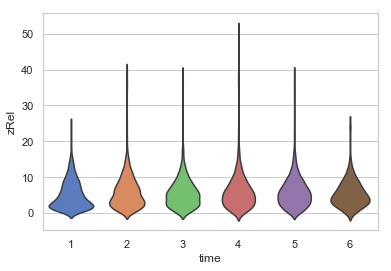

In [47]:
ax = sns.violinplot(x="time", y="zRel", data=df, inner=None)

C:\Users\gronteix\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


36


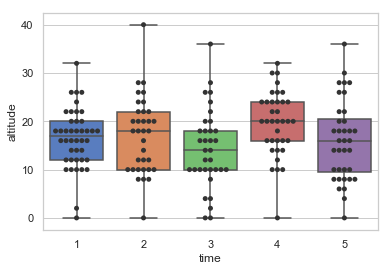

In [48]:
testFrame = df.loc[df['spheroid'] == '70']
testFrame['altitude'] = testFrame['zRel']*2

print(len(testFrame.loc[testFrame['time'] == '5']))

sns.set(style="whitegrid", palette="muted")

# Draw a categorical scatterplot to show each observation
sns.swarmplot(x="time", y="altitude", data=testFrame, color=".2")
sns.boxplot(x="time", y="altitude",  data=testFrame, whis=np.inf)

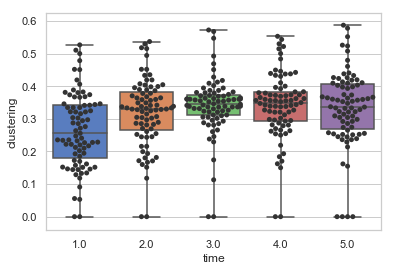

In [51]:
import pandas as pd
import seaborn as sns

plotData = df.loc[df['time'] < 6]

sns.set(style="whitegrid", palette="muted")

# Draw a categorical scatterplot to show each observation
sns.swarmplot(x="time", y="clustering", data=plotData, color=".2")
sns.boxplot(x="time", y="clustering",  data=plotData, whis=np.inf)

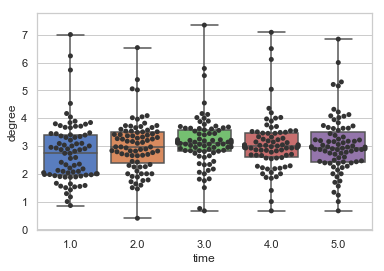

In [52]:
plotData = df.loc[df['time'] < 6]

sns.set(style="whitegrid", palette="muted")

# Draw a categorical scatterplot to show each observation
sns.swarmplot(x="time", y="degree", data=plotData, color=".2")
sns.boxplot(x="time", y="degree",  data=plotData, whis=np.inf)

In [53]:
def _binData(df, var, nBins):
    
    xMin = df[var].min()
        
    for x in np.linspace(df[var].min(), df[var].max(), nBins):
        
        print(x)
        
        df.loc[(df[var] <= x) & (df[var] > xMin), 'bin'] = int(x)
        
        xMin = x
        
    return df

In [54]:
newdf = _binData(df, 'n', 10)

5.0
35.55555555555556
66.11111111111111
96.66666666666667
127.22222222222223
157.77777777777777
188.33333333333334
218.8888888888889
249.44444444444446
280.0


In [55]:
sorted(newdf['bin'].unique())

[35.0, 66.0, 96.0, 127.0, 157.0, nan, 218.0, 249.0, 280.0]

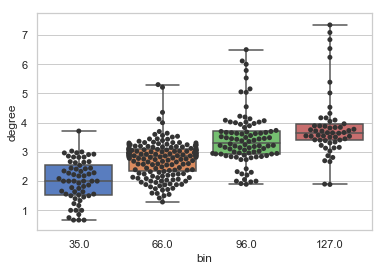

In [56]:
plotData = newdf.loc[(newdf['time'] < 6) & (newdf['bin'] < 150)]

sns.set(style="whitegrid", palette="muted")

# Draw a categorical scatterplot to show each observation
sns.swarmplot(x="bin", y="degree", data=plotData, color=".2")
sns.boxplot(x="bin", y="degree",  data=plotData, whis=np.inf)

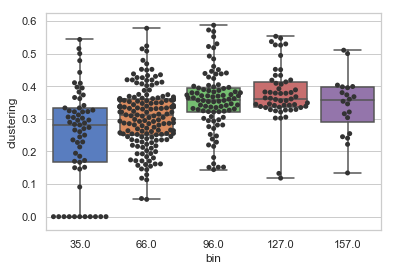

In [57]:
plotData = newdf.loc[(newdf['time'] < 6) & (newdf['bin'] < 160)]

sns.set(style="whitegrid", palette="muted")

# Draw a categorical scatterplot to show each observation
sns.swarmplot(x="bin", y="clustering", data=plotData, color=".2")
sns.boxplot(x="bin", y="clustering",  data=plotData, whis=np.inf)

C:\Users\gronteix\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


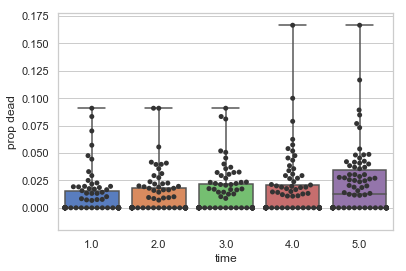

In [58]:
plotData = newdf.loc[(newdf['time'] < 6) & (newdf['bin'] < 160)]
plotData['prop dead'] = plotData['nDead']/plotData['n']

sns.set(style="whitegrid", palette="muted")

# Draw a categorical scatterplot to show each observation
sns.swarmplot(x="time", y="prop dead", data=plotData, color=".2")
sns.boxplot(x="time", y="prop dead",  data=plotData, whis=np.inf)

In [59]:
plotFrame = pandas.DataFrame()
i = 0

for t in plotData['time'].unique():
    plotFrame.loc[i, 'time'] = t
    plotFrame.loc[i, 'n'] = len(plotData.loc[(plotData['time'] == t)])
    plotFrame.loc[i, 'with death'] = plotData.loc[(plotData['time'] == t) & (plotData['prop dead'] > 0), 'prop dead'].mean()
    plotFrame.loc[i, 'prop. sph. with death'] = len(plotData.loc[(plotData['time'] == t) & (plotData['prop dead'] > 0)])/len(plotData.loc[(plotData['time'] == t)])
    i += 1


In [60]:
for label in df['label'].unique():
    
    df.loc[(df['label'] == label), 'nprop'] = df.loc[(df['label'] == label), 'n']/df.loc[(df['label'] == label), 'n'].max()

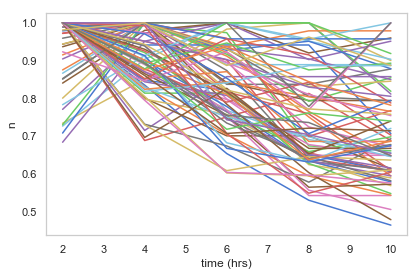

In [61]:
fig, ax1 = plt.subplots()

for label in df['label'].unique():
    
    loc = df.loc[(df['label'] == label) & (df['time'] < 6)]

    ax1.plot(2*(loc['time']), loc['nprop'])

    ax1.set_xlabel('time (hrs)')

# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('n')
ax1.tick_params('y')
ax1.grid(False)

fig.tight_layout()
plt.show()

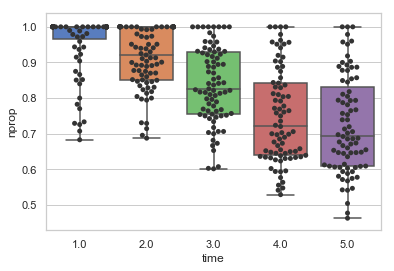

In [62]:
plotData = df.loc[(df['time'] < 6)]

sns.set(style="whitegrid", palette="muted")

# Draw a categorical scatterplot to show each observation
sns.swarmplot(x="time", y="nprop", data=plotData, color ="0.2")
sns.boxplot(x="time", y="nprop",  data=plotData, whis=np.inf)

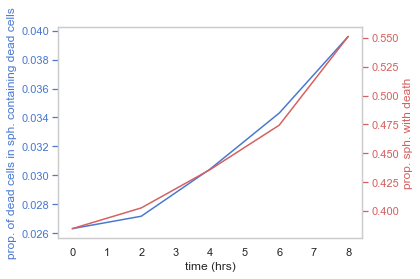

In [63]:
fig, ax1 = plt.subplots()

ax1.plot(2*(plotFrame['time']-1), plotFrame['with death'], 'b-')
ax1.set_xlabel('time (hrs)')

# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('prop. of dead cells in sph. containing dead cells', color='b')
ax1.tick_params('y', colors='b')
ax1.grid(False)

ax2 = ax1.twinx()
ax2.plot(2*(plotFrame['time']-1), plotFrame['prop. sph. with death'], 'r-')
ax2.set_ylabel('prop. sph. with death', color='r')
ax2.tick_params('y', colors='r')
ax2.grid(False)

fig.tight_layout()
plt.show()

[Text(0,0,'6'),
 Text(0,0,'5'),
 Text(0,0,'4'),
 Text(0,0,'3'),
 Text(0,0,'2'),
 Text(0,0,'1'),
 Text(0,0,'0'),
 Text(0,0,'7'),
 Text(0,0,'8'),
 Text(0,0,'9'),
 Text(0,0,'10'),
 Text(0,0,'11'),
 Text(0,0,'13'),
 Text(0,0,'12'),
 Text(0,0,'14')]

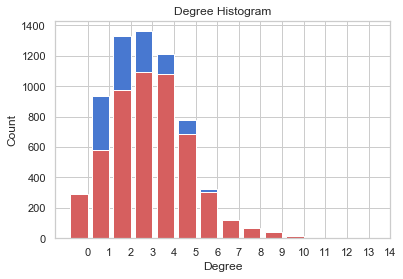

In [69]:
fig, ax = plt.subplots()
plt.bar(deg1, cnt1, width=0.80, color='b')
plt.bar(deg2, cnt2, width=0.80, color='r')


plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

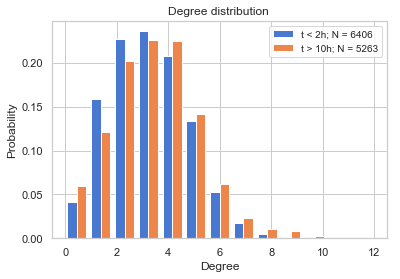

In [89]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.hist([deg1, deg2], 13, range = (0, 12), density=True, histtype='bar',  label=['t < 2h; N = ' + str(len(deg1)), 't > 10h; N = ' + str(len(deg2))])
ax.legend(prop={'size': 10})
ax.set_title('Degree distribution ')
plt.ylabel('Probability')
plt.xlabel('Degree')
plt.show()

In [ ]:
fig, ax = plt.subplots()
dist.plot.kde(ax=ax, legend=False, title='Histogram: A vs. B')
dist.plot.hist(density=True, ax=ax)
ax.set_ylabel('Probability')
ax.grid(axis='y')
ax.set_facecolor('#d8dcd6')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math

# poisson function, parameter lamb is the fit parameter
def poisson(k, lamb):
    return (lamb**k/math.factorial(k))*np.exp(-lamb)

l = np.dot(np.asarray(list(deg)),np.asarray(list(cnt)))/np.sum(np.asarray(list(cnt)))

plt.plot(deg, poisson(np.asarray(list(deg)), l), 'r-', lw=2)
plt.show()

In [ ]:
%matplotlib
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# What follows is a copy of the 3D plot example code.
# Data is randomly generated so there is no external data import.

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['x'], df['y'], df['z'])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_zlim(0,51)

plt.show()


from matplotlib_scalebar.scalebar import ScaleBar

for n in range(len(mask_img)):

    plt.subplot(111)
    plt.imshow(mask_img[n], cmap=plt.cm.gray, alpha = 0.8)
    plt.axis('off')
    
    scalebar = ScaleBar(0.000001, location = 'lower right') # 1 pixel = 0.2 meter
    plt.gca().add_artist(scalebar)

    lf = df.loc[df['z'] == n]
    mf = df.loc[df['z'] == n-1]
    pf = df.loc[df['z'] == n+1]

    plt.plot(mf['y'], mf['x'], 'go', label = 'z = ' + str(n-1))
    plt.plot(lf['y'], lf['x'], 'yo', label = 'z = ' + str(n))
    plt.plot(pf['y'], pf['x'], 'ro', label = 'z = ' + str(n+1))

    plt.show()
    plt.legend()
    
    plt.savefig(r'/Users/gustaveronteix/Desktop/Image Stack/filmstack/im_' + str(n) +'.png')
    plt.close()

In [ ]:
import networkx as nx
G=nx.Graph()

In [ ]:
G.add_nodes_from(_Cells.keys())

In [ ]:
for key in _Cells.keys():
    
    neighbours = _Cells[key]['neighbours']
    
    for node in neighbours:
    
        G.add_edge(key, node)

In [ ]:
zAlt = []

for key in _Cells.keys():
        
    zAlt.append(_Cells[key]['z'])

In [ ]:
plt.figure()

pos = nx.spring_layout(G)
im = nx.draw_networkx_nodes(G, pos, node_size=20, node_color = zAlt, cmap=plt.cm.viridis)
nx.draw_networkx_edges(G, pos, alpha=0.4)
plt.colorbar(im)
plt.show()